# DML

In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

/Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred)
    plt.plot(np.sort(effect_true), np.sort(effect_true), alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### 00. data

In [3]:
# Train set
train = pd.read_csv(r'./data/ml_earnings_train.csv')

# Test set
test = pd.read_csv(r'./data/ml_earnings_test.csv')

- train 데이터는 RCT를 통해서 얻은 데이터이여야 한다.
- test 데이터에서 `true_effect`는 실제로는 절대 알 수 없고 학습용으로 만든 데이터이다.

In [4]:
train.head(3)

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0


In [5]:
test.head(3)

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0


### 01. graph

In [6]:
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'


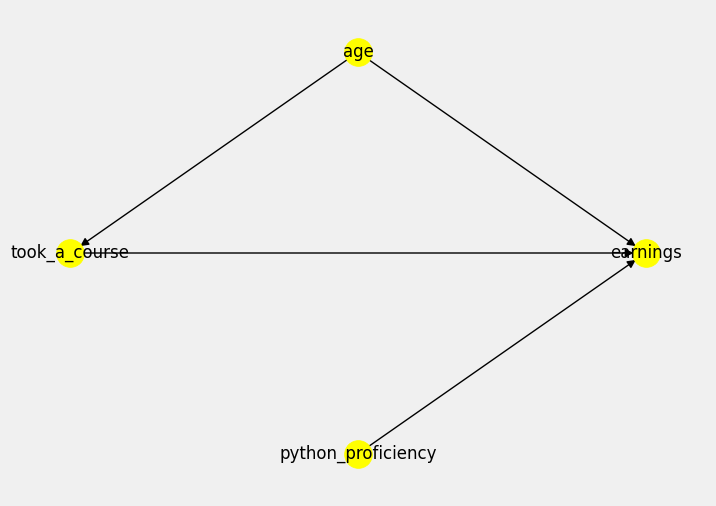

In [7]:
# Instantiate the CausalModel 
model = CausalModel(
    data=train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

model.view_model()

### 02. estimand

In [8]:
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 03. estimate effect

In [ ]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True
        },
        'fit_params': {}
    }
)

In [10]:
estimate.cate_estimates.mean()

### Predict test

- 아직 위의 코드 버전업된 경우 확인하지 못함 -> econml 사용

In [14]:
effect_true = test['true_effect'].values

In [12]:
from econml.dml import LinearDML

est = LinearDML(discrete_treatment=True)
est.fit(Y=train['earnings'], T=train['took_a_course'], X=train.drop(['earnings', 'took_a_course'], axis=1))
effect_pred = est.effect(test.drop(['true_effect', 'took_a_course'], axis=1))

In [15]:
mean_absolute_percentage_error(effect_true, effect_pred)

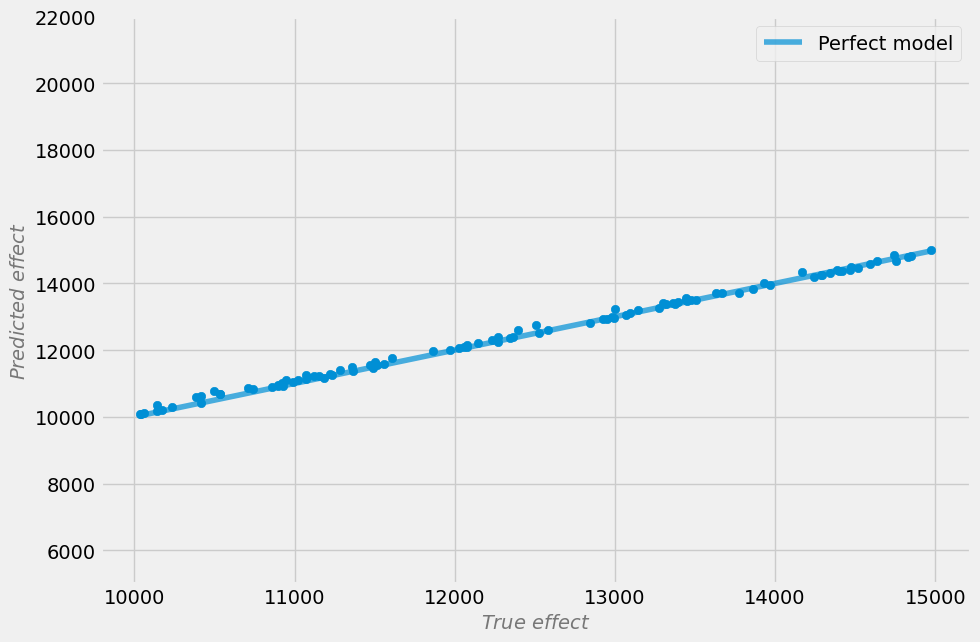

In [16]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

- 이전 S-learner보다 정확하다.